# Implementación del índice de disponibilidad (ida)

En este notebook, se presenta el procedimiento utilizado para llevar a cabo la implementación del índice de disponibilidad basado en los criterios generados por Michelle. 

In [1]:
# Librerías

# Manipulación y visualización de datos
import pandas as pd 
import geopandas as gpd
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib


# Warnings
import warnings

In [2]:
warnings.filterwarnings('ignore')
matplotlib.rcParams['font.sans-serif'] = ['Source Han Sans TW', 'sans-serif']
matplotlib.rcParams['grid.color'] = 'k'
matplotlib.rcParams['grid.linestyle'] = '-'
matplotlib.rcParams['grid.linewidth'] = 0.5
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['legend.fontsize'] = 'medium'
matplotlib.rcParams['figure.titlesize'] = 'large'
matplotlib.rcParams["font.family"] = "serif"

In [3]:
# Lectura de los datasets, con su descripción
data = pd.read_csv('./primary_dataset_v1.csv', index_col=0)
descr = pd.read_excel('./primary_dataset_v1_description.xlsx', index_col=0)

In [4]:
# Para la variable de disponibilidad, es importante sólamente utilizar los parámetros únicos:
params = ['clave_monitoreo', 'latitud','longitud','eda','uso_suelo','textura','lito','fasefis']
disponibilidad = data[params]

In [5]:
# Criterios para generar el índice de disponibilidad:

# Fase física
def fasefis_coef(x):
    try:
        if 'fragica' in x:
            return 0.8
        if 'litica' in x:
            return 0.7
        if 'petrocalcica' in x:
            return 0.6
        if 'gravosa' in x:
            return 0.5
        if "pedregosa" in x:
            return 0.5
        if 'petrogypsica' in x:
            return 0.4
        if 'durica' in x: 
            return 0.2
        else:
            return np.random.randint(1, 9)*.1
    except:
        return np.random.randint(1, 9)*.1
    
# Litografía
def lito_coef(x):
    if 'baja a alta' in x:
        return 0.7
    if 'media a alta' in x:
        return 0.8
    if 'baja a media' in x:
        return 0.6
    if 'alta' in x:
        return 0.9
    if 'baja' in x:
        return 0.4
    if 'cuerpos de agua' in x:
        return 1
    else:
        return np.random.randint(1, 9)*.1
    
# Uso de suelo
def uso_suelo_coef(x):
    if 'bosque' in x:
        return 0.9
    if ('selva' in x) or ('manglar' in x) or ('popal' in x) or ('tular' in x):
        return 0.8
    if (('acuicola' in x) or 
        ('agricultura' in x) or
    ('pradera' in x)or
    ('pastizal' in x) or
    ('palmar' in x)):
        return 0.7
    if 'zona urbana' in x or 'asentamientos humanos' in x:
        return 0.6
    if (('matorral' in x) or
    ('chaparral' in x)  or
    ('sabana' in x) or
    ('mezquital' in x) or
    ('sabanoide' in x)):
        return 0.5
    else:
        return np.random.randint(1, 9)*.1

# textura
def textura_coef(x):
    try:
        if 'fina' in x: 
            return 0.4
        if 'media' in x:
            return 0.6
        if 'gruesa' in x:
            return 0.9
        else:
            np.random.randint(1, 9)*.1
    except:
        return np.random.randint(1, 9)*.1

# Edafología
def eda_coef(x):
    try:
        bajo = ['acrisol','alisol','planosol','kastanozem','xerosol','yermosol','regosol',
               'vertisol']
        if any([(element in x) for element in bajo]):
            return 0.4
        medio = ['cambisol','ferralsol','rendzina','solonchak','solonetz','gleysol','ranker','leptosol']
        if any([(element in x) for element in medio]):
            return 0.5
        alto = ['chernozen','luvisol','calcisol','nitosol','feozem','plinthosol',
                'litisol','podzoluvisol','podzol']
        if any([(element in x) for element in alto]):
            return 0.8
        muy_alto = ['arenosol','cumulic','aric','fluvisol','greyzem','histosol','andosol'
                   'lixisol','rendzina']
        if any([(element in x) for element in muy_alto]):
            return 0.9
        else:
            return np.random.randint(1, 9)*.1
    except:
        return np.random.randint(1, 9)*.1


In [6]:
disponibilidad['fasefis_coef'] = disponibilidad.fasefis.apply(fasefis_coef)
disponibilidad['lito_coef'] = disponibilidad.lito.apply(lito_coef)
disponibilidad['uso_suelo_coef'] = disponibilidad.uso_suelo.apply(uso_suelo_coef)
disponibilidad['textura_coef'] = disponibilidad.textura.apply(textura_coef)
disponibilidad['eda_coef'] = disponibilidad.eda.apply(eda_coef)

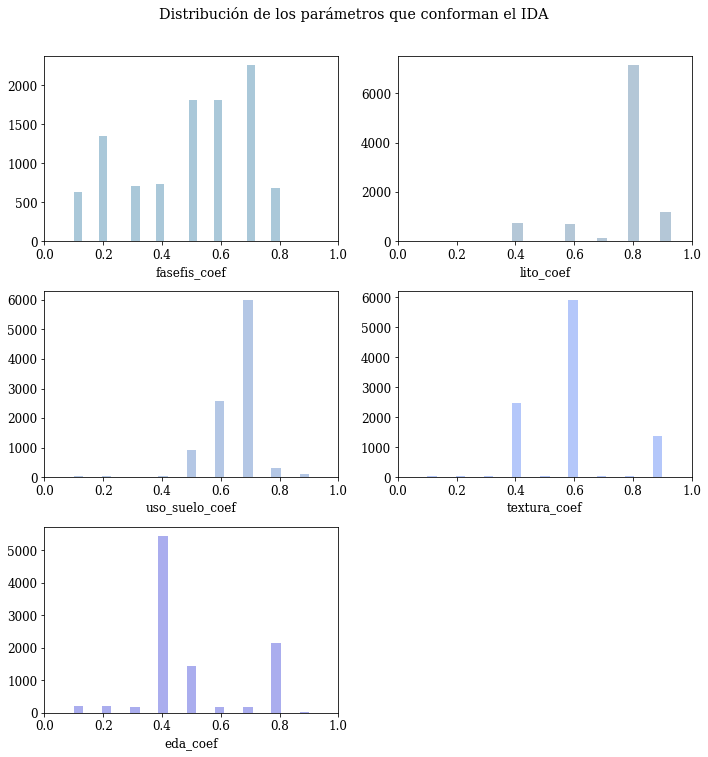

In [35]:
coef_list = [w for w in disponibilidad.columns if "coef" in w]
colors = ['#2C77A2', '#45759D','#4575C0','#4575F3','#2C33D5']
plt.figure(figsize=(10,10))
for i,word in enumerate(coef_list):
    plt.subplot(3,2,i+1)
    sns.distplot(
        disponibilidad[word],
        kde=False,
        color=colors[i],
        bins=25)
    plt.xlim(0,1)
    plt.suptitle("Distribución de los parámetros que conforman el IDA", y=1.05)
plt.tight_layout()

In [8]:
## Primer propuesta: multiplicación simple:


In [45]:
disponibilidad['ida1'] = (disponibilidad.fasefis.apply(fasefis_coef)*
             disponibilidad.lito.apply(lito_coef)*
             disponibilidad.uso_suelo.apply(uso_suelo_coef)*
             disponibilidad.textura.apply(textura_coef)*
             disponibilidad.eda.apply(eda_coef))

Text(0.5, 0, 'IDA$_{1}$')

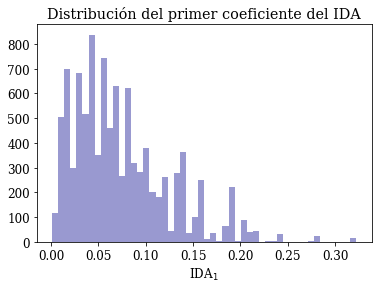

In [50]:
sns.distplot(disponibilidad['ida1'], kde=False, bins=50, color="#00008B")
plt.title('Distribución del primer coeficiente del IDA')
plt.xlabel("IDA$_{1}$")

Text(0.5, 1, 'Representación geográfica del IDA$_{1}$')

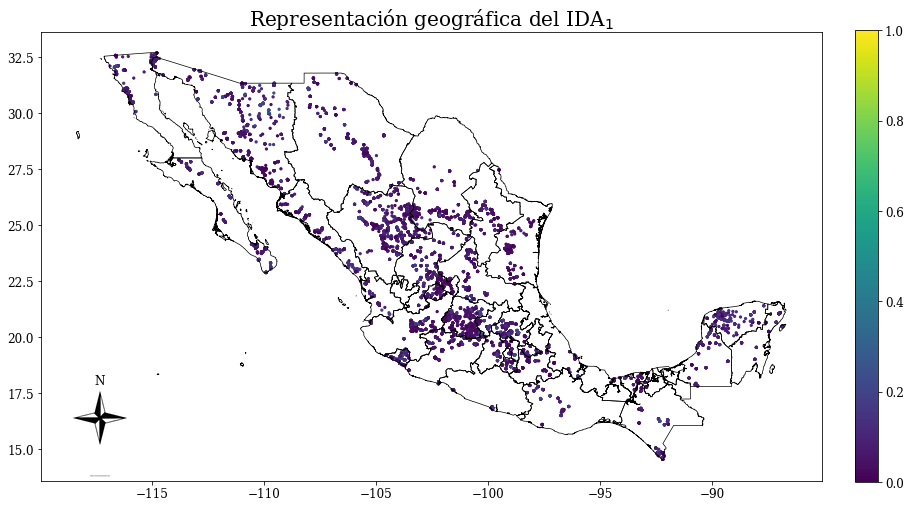

In [122]:
from PIL import Image

geo_data = gpd.read_file("./destdv250k_2gw.shx")
geo_data.boundary.plot(linewidth=.7, color="black", figsize=(15, 10))
sc = plt.scatter(disponibilidad.longitud,
                 disponibilidad.latitud, 
                 c=disponibilidad.ida1, 
                 s=5, 
                 vmin=0.0, 
                 vmax=1.0)
im =  Image.open("./image-formats/rosa-de-vientos3.png")
im.thumbnail((120, 120), Image.ANTIALIAS)
plt.text(-117.55,17.9, "N",)
plt.figimage(im, 40, 30)
plt.colorbar(sc, fraction=0.027, pad=0.04)
plt.title("Representación geográfica del IDA$_{1}$", fontsize=20)
plt.show()

Text(0.5, 0, 'IDA$_{2}$')

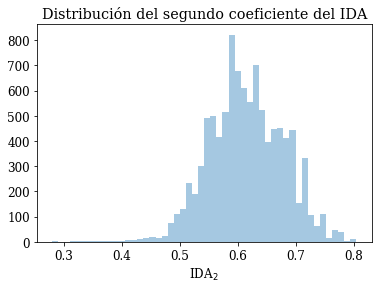

In [125]:
disponibilidad['ida2'] = (
    0.10*disponibilidad.fasefis.apply(fasefis_coef)+
    0.15*disponibilidad.lito.apply(lito_coef)+
    0.40*disponibilidad.uso_suelo.apply(uso_suelo_coef)+
    0.15*disponibilidad.textura.apply(textura_coef)+
    0.20*disponibilidad.eda.apply(eda_coef)
)


# disponibilidad['ida2'] = (
#     0.10*disponibilidad.fasefis.apply(fasefis_coef)+
#     0.10*disponibilidad.lito.apply(lito_coef)+
#     0.30*disponibilidad.uso_suelo.apply(uso_suelo_coef)+
#     0.25*disponibilidad.textura.apply(textura_coef)+
#     0.25*disponibilidad.eda.apply(eda_coef)
# )

sns.distplot(disponibilidad['ida2'], kde=False)
plt.title('Distribución del segundo coeficiente del IDA')
plt.xlabel("IDA$_{2}$")

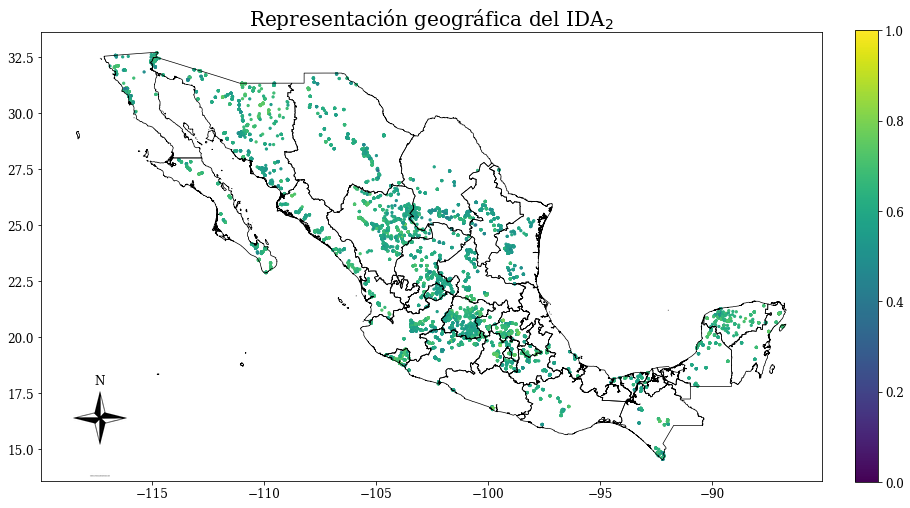

In [123]:
geo_data.boundary.plot(linewidth=.7, color="black", figsize=(15, 10))
sc = plt.scatter(disponibilidad.longitud,
                 disponibilidad.latitud, 
                 c=disponibilidad.ida2, 
                 s=5, 
                 vmin=0.0, 
                 vmax=1.0)
plt.text(-117.55,17.9, "N",)
plt.figimage(im, 40, 30)
plt.colorbar(sc, fraction=0.027, pad=0.04)
plt.title("Representación geográfica del IDA$_{2}$", fontsize=20)
plt.show()

In [126]:
from sklearn.cluster import KMeans


In [127]:
coefs = [col for col in disponibilidad.columns if (('coef' in col))] + ['ida2','ida']

In [128]:
clusters = 100
y_pred = KMeans(n_clusters=clusters).fit_predict(disponibilidad[coefs])

In [129]:
disponibilidad['ans'] = y_pred

In [130]:
v = (disponibilidad.groupby("ans")
     .mean()[['ida','ida2']].mean(axis=1)
     .sort_values()
     .reset_index().reset_index())
v['index']=v['index']/clusters
v.columns = ['IDA','ans','C']
v = v[['ans', 'IDA']]

In [131]:
disponibilidad2 = disponibilidad.merge(v, on='ans')

Text(0.5, 0, 'IDA')

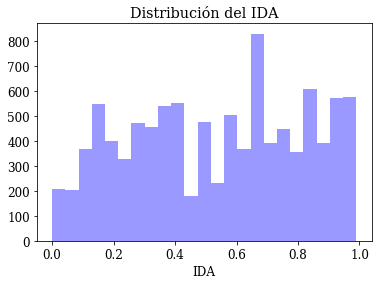

In [137]:
sns.distplot(disponibilidad2['IDA'], kde=False, color="blue")
plt.title('Distribución del IDA')
plt.xlabel("IDA")

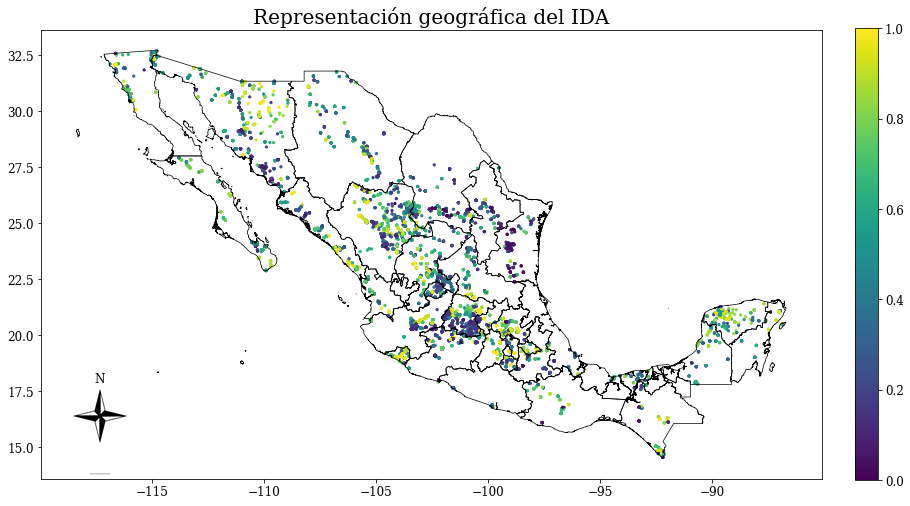

In [141]:
geo_data.boundary.plot(linewidth=.7, color="black", figsize=(15, 10))
sc = plt.scatter(disponibilidad2.longitud,
                 disponibilidad2.latitud, 
                 c=disponibilidad2.IDA, 
                 s=5, 
                 vmin=0.0, 
                 vmax=1.0)
plt.text(-117.55,17.9, "N",)
plt.figimage(im, 40, 30)
plt.colorbar(sc, fraction=0.027, pad=0.04)
plt.title("Representación geográfica del IDA", fontsize=20)
plt.show()

In [231]:
non_wanted_list = ['latitud','longitud','eda', 'uso_suelo','textura','lito','fasefis']
data2 = data.merge(disponibilidad2.drop(non_wanted_list, axis=1), on='clave_monitoreo')
data2

,clave_monitoreo,clave_sitio,nombre_sitio,organismo_cuenca,estado,municipio,cuerpo_agua,tipo_cuerpo_agua,subtipo_cuerpo_agua,año,...,wind_gust,fasefis_coef,lito_coef,uso_suelo_coef,textura_coef,eda_coef,ida,ida2,ans,IDA
0,dlagu19-021212,dlagu19,pozo paso blanco,lerma santiago pacífico,aguascalientes,jesús maría,acuífero valle de aguascalientes,subterráneo,pozo,2012,...,NaN,0.2,0.8,0.7,0.6,0.4,0.02688,0.590,39,0.38
1,dlagu19-260513,dlagu19,pozo paso blanco,lerma santiago pacífico,aguascalientes,jesús maría,acuífero valle de aguascalientes,subterráneo,pozo,2013,...,NaN,0.2,0.8,0.7,0.6,0.4,0.02688,0.590,39,0.38
2,dlagu19-270714,dlagu19,pozo paso blanco,lerma santiago pacífico,aguascalientes,jesús maría,acuífero valle de aguascalientes,subterráneo,pozo,2014,...,NaN,0.2,0.8,0.7,0.6,0.4,0.02688,0.590,39,0.38
3,dlagu19-190415,dlagu19,pozo paso blanco,lerma santiago pacífico,aguascalientes,jesús maría,acuífero valle de aguascalientes,subterráneo,pozo,2015,...,NaN,0.2,0.8,0.7,0.6,0.4,0.02688,0.590,39,0.38
4,dlagu19-140216,dlagu19,pozo paso blanco,lerma santiago pacífico,aguascalientes,jesús maría,acuífero valle de aguascalientes,subterráneo,pozo,2016,...,NaN,0.2,0.8,0.7,0.6,0.4,0.02688,0.590,39,0.38
5,dlagu19-090717,dlagu19,pozo paso blanco,lerma santiago pacífico,aguascalientes,jesús maría,acuífero valle de aguascalientes,subterráneo,pozo,2017,...,NaN,0.2,0.8,0.7,0.6,0.4,0.02688,0.590,39,0.38
6,dlagu19-110318,dlagu19,pozo paso blanco,lerma santiago pacífico,aguascalientes,jesús maría,acuífero valle de aguascalientes,subterráneo,pozo,2018,...,NaN,0.2,0.8,0.7,0.6,0.4,0.02688,0.590,39,0.38
7,dlagu19-021218,dlagu19,pozo paso blanco,lerma santiago pacífico,aguascalientes,jesús maría,acuífero valle de aguascalientes,subterráneo,pozo,2018,...,2.65,0.2,0.8,0.7,0.6,0.4,0.02688,0.590,39,0.38
8,dlagu19-160619,dlagu19,pozo paso blanco,lerma santiago pacífico,aguascalientes,jesús maría,acuífero valle de aguascalientes,subterráneo,pozo,2019,...,3.61,0.2,0.8,0.7,0.6,0.4,0.02688,0.590,39,0.38
9,dlagu1m1-251112,dlagu1m1,pozo de la comunidad de los duron,lerma santiago pacífico,aguascalientes,aguascalientes,acuífero el llano,subterráneo,pozo,2012,...,NaN,0.2,0.8,0.7,0.6,0.4,0.02688,0.590,39,0.38
